<h1><center>Meat Quality Assessment</center></h1>

<center><img src="https://im.haberturk.com/2019/02/23/ver1550911120/2382763_810x458.jpg"></center>

# **Contents**

1. [Import data and python packages](#t1.)


2. [Data visualization](#t2.)


3. [Classification (CNN)](#t3.)


4. [Prediction](#t4.)

<a id="t1."></a>
# 1. Import data and python packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
from IPython.display import clear_output

In [5]:
for root, dirs, files in os.walk('./data'):
    print(root)
    for file in files:
        print(f"  {file}")

In [6]:
import os
import zipfile

# Assuming you've uploaded 'lockBEEF.zip' to JupyterLab
zip_path = 'FinalTest11.zip'  # path to the zip file
extract_path = 'extracted_FinalTest11'  # folder where the contents will be extracted

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Now adjust your script to work with the extracted directories
files = ['beef', 'fake_beef']
data = {f: [] for f in files}

# Loop through fresh and rotten directories inside the extracted 'lockBEEF' folder
for col in files:
    # Construct the path to the extracted directory
    dir_path = os.path.join(extract_path, 'FinalTest11', col)  # assuming the structure is lockBEEF/fresh and lockBEEF/rotten
    for i in os.listdir(dir_path):
        if i.endswith('.jpg') or i.endswith('.png'):
            data[col].append(i)

# Print the collected data
print(data)

{'beef': ['20210830_A01_1.jpg', '20210830_A01_10.jpg', '20210830_A01_10_seg.jpg', '20210830_A01_1_seg.jpg', '20210830_A01_2.jpg', '20210830_A01_2_seg.jpg', '20210830_A01_3.jpg', '20210830_A01_3_seg.jpg', '20210830_A01_4.jpg', '20210830_A01_4_seg.jpg', '20210830_A01_5.jpg', '20210830_A01_5_seg.jpg', '20210830_A01_6.jpg', '20210830_A01_6_seg.jpg', '20210830_A01_7.jpg', '20210830_A01_7_seg.jpg', '20210830_A01_8.jpg', '20210830_A01_8_seg.jpg', '20210830_A01_9.jpg', '20210830_A01_9_seg.jpg', '20210903_A01_1.jpg', '20210903_A01_10.jpg', '20210903_A01_10_seg.jpg', '20210903_A01_1_seg.jpg', '20210903_A01_2.jpg', '20210903_A01_2_seg.jpg', '20210903_A01_3.jpg', '20210903_A01_3_seg.jpg', '20210903_A01_4.jpg', '20210903_A01_4_seg.jpg', '20210903_A01_5.jpg', '20210903_A01_5_seg.jpg', '20210903_A01_6.jpg', '20210903_A01_6_seg.jpg', '20210903_A01_7.jpg', '20210903_A01_7_seg.jpg', '20210903_A01_8.jpg', '20210903_A01_8_seg.jpg', '20210903_A01_9.jpg', '20210903_A01_9_seg.jpg', '20210906_S01_1.jpg', '202

In [7]:
import pandas as pd
import numpy as np

# Tìm độ dài nhỏ nhất của các danh sách
min_len = min([len(v) for v in data.values()])

# Đưa tất cả các danh sách về cùng độ dài bằng cách cắt bớt
for key in data:
    data[key] = data[key][:min_len]  # Cắt bớt danh sách về chiều dài tối thiểu

# Tạo DataFrame
df = pd.DataFrame(data)
print(df.head())


                      beef fake_beef
0       20210830_A01_1.jpg    a1.png
1      20210830_A01_10.jpg   a10.png
2  20210830_A01_10_seg.jpg   a11.png
3   20210830_A01_1_seg.jpg   a12.png
4       20210830_A01_2.jpg   a13.png


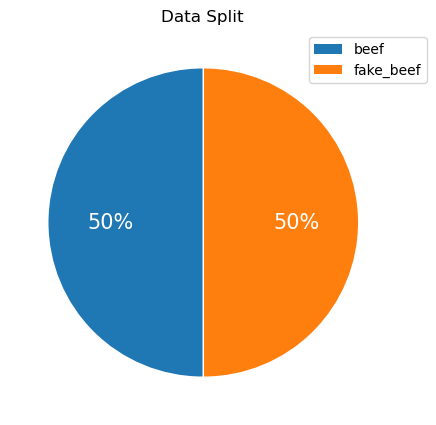

In [8]:
sizes = [len(data['beef']), len(data['fake_beef'])]

plt.figure(figsize=(10,5), dpi=100)

plt.pie(x=sizes,autopct='%1.0f%%',shadow=False, textprops={'color':"w","fontsize":15}, startangle=90,explode=(0,.01))
plt.legend(files,bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [9]:
import time
import cv2
import os
import numpy as np
import pandas as pd
from IPython.display import clear_output
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

# Khởi tạo thời gian và danh sách cho dữ liệu ảnh và nhãn
start = time.time()
image_data = []
image_target = []
lockbeef_folder = 'FinalTest11'
extract_path = 'extracted_FinalTest11'  # Đường dẫn đến thư mục đã giải nén
files = ['beef', 'fake_beef']   # Danh sách các lớp
width, height = 224, 224  # Kích thước mong muốn
sample_size = 2000  # Giới hạn số lượng ảnh mỗi lớp

# Kiểm tra số lượng ảnh trong từng thư mục và lưu vào từ điển
data = {title: [] for title in files}
for title in files:
    dir_path = os.path.join(extract_path, lockbeef_folder, title)
    if os.path.exists(dir_path):
        data[title] = os.listdir(dir_path)  # Lưu danh sách tên ảnh vào từ điển
        print(f"Number of images in {title}: {len(data[title])}")
    else:
        print(f"Directory does not exist: {dir_path}")

# Khởi tạo các phép biến đổi tăng cường dữ liệu
augmentation_sequence = iaa.Sequential([
    iaa.Fliplr(0.5),  # Lật ngang với xác suất 50%
    iaa.Affine(rotate=(-25, 25)),  # Xoay ngẫu nhiên từ -25 đến 25 độ
    iaa.Multiply((0.8, 1.2)),  # Thay đổi độ sáng
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Làm mờ
])

# Phân đoạn và xử lý ảnh
for title in files:
    dir_path = os.path.join(extract_path, lockbeef_folder, title)

    if not os.path.exists(dir_path):
        print(f"Thư mục không tồn tại: {dir_path}")
        continue
    
    counter = 0
    print(f"Đang xử lý lớp: {title}")

    for image_name in data[title]:  # Duyệt qua danh sách đã được cắt bớt
        img_path = os.path.join(dir_path, image_name)
        img = cv2.imread(img_path)

        if img is not None:
            try:
                # Phân đoạn ảnh
                image_blurred = cv2.GaussianBlur(img, (7, 7), 0)
                hsv = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2HSV)
                lower_red_dark = np.array([0, 50, 30])
                upper_red_dark = np.array([10, 255, 255])
                lower_red_dark_2 = np.array([160, 50, 30])
                upper_red_dark_2 = np.array([180, 255, 255])
                
                # Tạo mặt nạ cho màu đỏ sậm
                mask_red_dark_1 = cv2.inRange(hsv, lower_red_dark, upper_red_dark)
                mask_red_dark_2 = cv2.inRange(hsv, lower_red_dark_2, upper_red_dark_2)
                mask_red_dark = cv2.bitwise_or(mask_red_dark_1, mask_red_dark_2)
                
                # Sử dụng phép toán hình thái học để lấy được toàn bộ miếng thịt
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
                final_mask_cleaned = cv2.morphologyEx(mask_red_dark, cv2.MORPH_CLOSE, kernel)
                
                # Tìm contours và giữ lại các vùng lớn
                contours, _ = cv2.findContours(final_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                mask_large_contours = np.zeros_like(final_mask_cleaned)
                
                # Giữ lại 1 contour cho beef và 3 contours cho pork
                if title == 'beef':
                    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]  # Giữ lại 1 contour lớn nhất cho beef
                elif title == 'pork':
                    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]  # Giữ lại 3 contours lớn nhất cho pork

                # Vẽ các contours lên mặt nạ
                for contour in contours:
                    cv2.drawContours(mask_large_contours, [contour], -1, (255), thickness=cv2.FILLED)

                # Áp dụng mặt nạ để phân đoạn ảnh
                segmented_image = cv2.bitwise_and(img, img, mask=mask_large_contours)
                
                # Cân bằng kích thước
                img_resized = cv2.resize(segmented_image, (width, height))
                
                # Tăng cường dữ liệu chỉ nếu img_resized được tạo thành công
                img_augmented = augmentation_sequence(images=[img_resized])[0]
                img_augmented = np.clip(img_augmented, 0, 255).astype(np.uint8)  # Đảm bảo giá trị nằm trong khoảng hợp lệ
                
                image_data.append(img_augmented)
                image_target.append(title)
                counter += 1
                if counter == sample_size:  # Giới hạn số lượng ảnh theo biến sample_size
                    break
            except Exception as e:
                print(f"Lỗi khi xử lý ảnh {img_path}: {e}")
        else:
            print(f"Không thể tải ảnh: {img_path}")

    clear_output(wait=True)
    print(f"Đã tổng hợp lớp {title}")

calculate_time = time.time() - start    
print(f"Tổng thời gian xử lý: {round(calculate_time, 5)} giây")


Đã tổng hợp lớp fake_beef
Tổng thời gian xử lý: 147.66448 giây


In [11]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(2727, 224, 224, 3)

<a id="t2."></a>
# 2. Data visualization

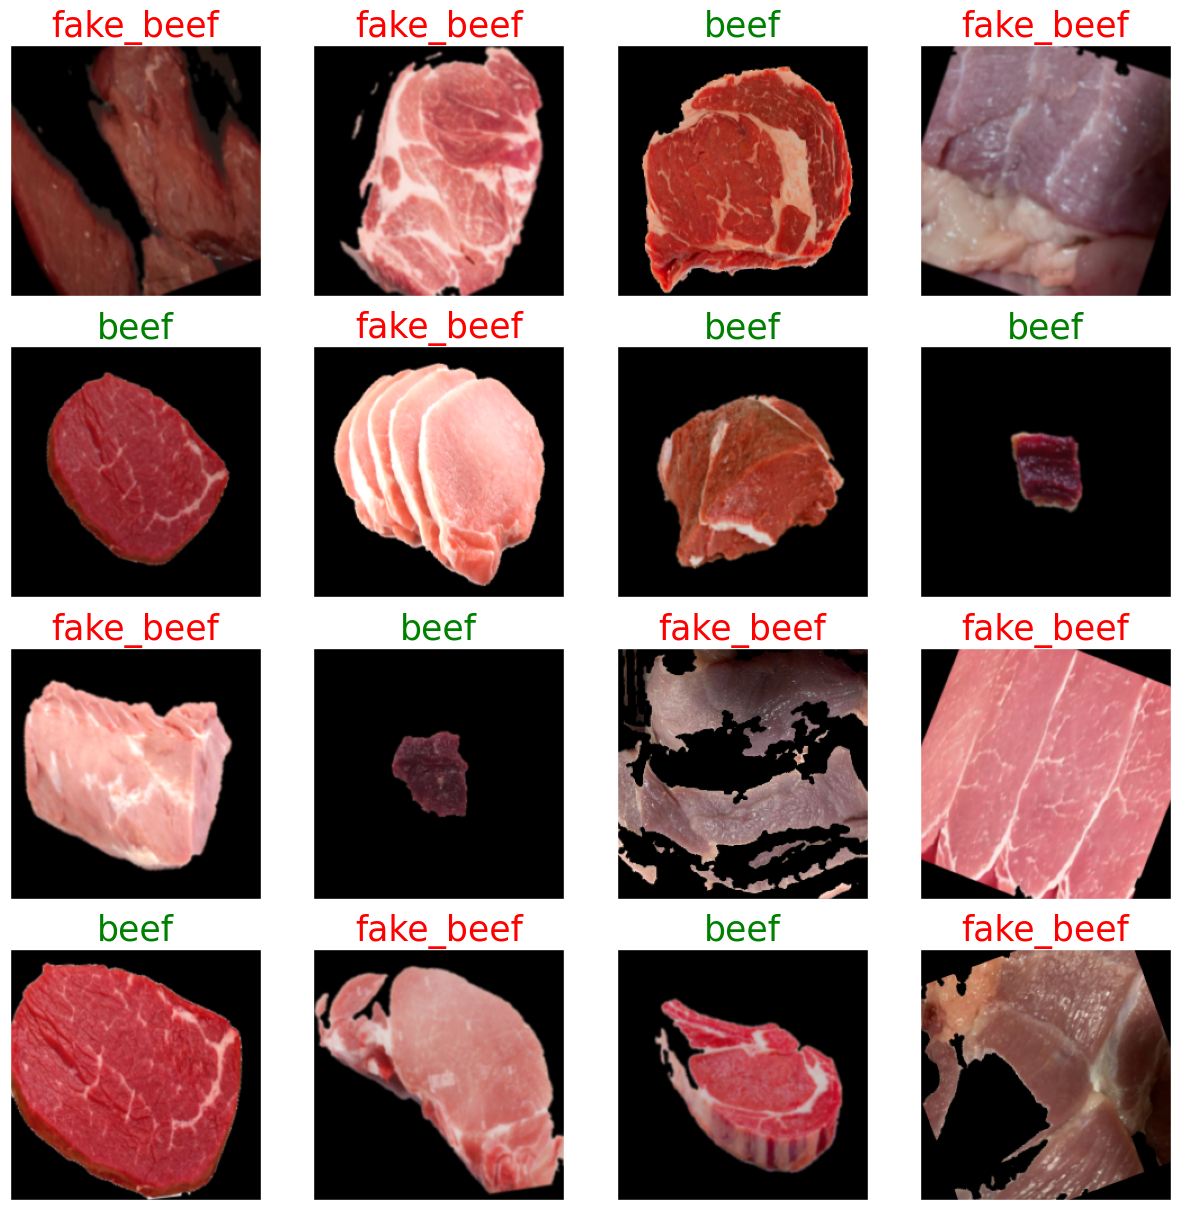

In [48]:
import matplotlib.pyplot as plt

# Giả sử 'size' là số lượng hình ảnh trong 'image_data'
size = len(image_data)

plt.figure(figsize=(15, 15))
for i in range(1, 17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4, 4, i)
    
    # Chuyển đổi từ BGR sang RGB nếu cần
    img_rgb = cv2.cvtColor(image_data[fig], cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)  # Hiển thị hình ảnh
    if image_target[fig] == 'beef':
        c = 'green'
    else:
        c = 'red'
    plt.title(image_target[fig], color=c,size=25)
    plt.xticks([]), plt.yticks([])

plt.show()


<a id="t3."></a>
# 3. Classification (CNN)

In [15]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNet

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling2D, Dense, Flatten, Dropout

from tensorflow.keras.layers import Reshape, Input

from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping

In [16]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [17]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tạo bộ dữ liệu tăng cường
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Áp dụng tăng cường dữ liệu cho bộ dữ liệu huấn luyện
datagen.fit(train_images)

In [19]:
#input_layer = Input(shape=(224, 224, 3))

#x = layers.Conv2D(35, (3, 3), activation='relu')(input_layer)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(128, (3, 3), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)

# Reshape để chuẩn bị cho lớp Attention
#x = layers.Reshape((26 * 26, 128))(x)

# Thêm MultiHeadAttention (Self-Attention)
#attention_output = MultiHeadAttention(num_heads=8, key_dim=128)(x, x)

#x = Flatten()(attention_output)
#x = layers.Dense(64, activation='relu')(x)
#output_layer = layers.Dense(2)(x)

# Định nghĩa mô hình
#model = models.Model(inputs=input_layer, outputs=output_layer)

In [20]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(35, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(2))

In [22]:
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình với cả hai callback
history_cnn = cnn_model.fit(
    train_images, 
    train_labels, 
    epochs=10, 
    validation_data=(test_images, test_labels)
    #callbacks=[early_stop]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8320 - loss: 0.5230 - val_accuracy: 0.9096 - val_loss: 0.2245
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9323 - loss: 0.1628 - val_accuracy: 0.9267 - val_loss: 0.1860
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9611 - loss: 0.0989 - val_accuracy: 0.9035 - val_loss: 0.1972
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9730 - loss: 0.0742 - val_accuracy: 0.9170 - val_loss: 0.2304
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9930 - loss: 0.0270 - val_accuracy: 0.9182 - val_loss: 0.2838
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9958 - loss: 0.0144 - val_accuracy: 0.9280 - val_loss: 0.2931
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9981 - loss: 0.0073 - val_accuracy: 0.9048 - val_loss: 0.3847
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9663 - loss: 0.0869 - val_accuracy: 0.9011 - val_loss:

In [24]:
#from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras import layers, models
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.callbacks import LearningRateScheduler
#from tensorflow.keras.layers import BatchNormalization

#base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#base_model.trainable = False

#model = models.Sequential()

#model.add(base_model)

#model.add(layers.GlobalAveragePooling2D())  
#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))  
#model.add(layers.Dense(32, activation='relu'))
#model.add(Dropout(0.5))  
#model.add(BatchNormalization()) 
#model.add(layers.Dense(2, activation='softmax'))  

#model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

#base_model.trainable = True

#for layer in base_model.layers[:100]: 
    #layer.trainable = False

#model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


In [25]:
# Sử dụng LearningRateScheduler để điều chỉnh learning rate trong quá trình huấn luyện
#def lr_scheduler(epoch, lr):
    #if epoch > 10:  
        #return lr * 0.5
    #return lr

#lr_callback = LearningRateScheduler(lr_scheduler)

#lr_callback = LearningRateScheduler(lr_scheduler)

# Tạo callback cho EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình với cả hai callback
#mobile_history = model.fit(
    #train_images, 
    #train_labels, 
    #epochs=50, 
    #validation_data=(test_images, test_labels),
    #callbacks=[lr_callback, early_stop]
#)


In [26]:
#from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10
                               #, restore_best_weights=True)
#history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[early_stopping])

In [27]:
#cnn_model.save("cnn_model.h5")

#model.save("mobilenet_model.h5")

#import os
#cnn_model_size = os.path.getsize("cnn_model.h5") / (1024 * 1024)  # Chuyển sang MB
#mobilenet_model_size = os.path.getsize("mobilenet_model.h5") / (1024 * 1024)  # Chuyển sang MB

#print(f"Kích thước mô hình CNN: {cnn_model_size:.2f} MB")
#print(f"Kích thước mô hình MobileNetV2: {mobilenet_model_size:.2f} MB")


In [28]:
# Đo thời gian dự đoán với CNN
#start_time = time.time()
#cnn_pred = cnn_model.predict(np.expand_dims(test_images[0], axis=0))  # Dự đoán cho một hình ảnh
#end_time = time.time()
#print(f"Thời gian dự đoán CNN: {end_time - start_time:.6f} giây")

# Đo thời gian dự đoán với MobileNetV2
#start_time = time.time()
#mobilenet_pred = model.predict(np.expand_dims(test_images[0], axis=0))  # Dự đoán cho một hình ảnh
#end_time = time.time()
#print(f"Thời gian dự đoán MobileNetV2: {end_time - start_time:.6f} giây")


26/26 - 7s - 259ms/step - accuracy: 0.9121 - loss: 0.4719


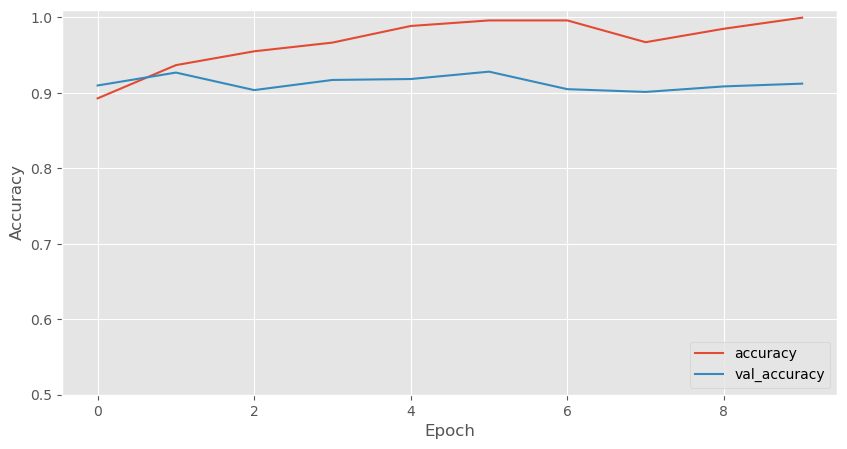

In [29]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(test_images,  test_labels, verbose=2)

In [30]:
result=cnn_model.evaluate(test_images, test_labels)

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.9039 - loss: 0.4941


In [31]:
for i in range(len(cnn_model.metrics_names)):
    print(cnn_model.metrics_names[i],":",result[i])

loss : 0.47193437814712524
compile_metrics : 0.9120879173278809


In [32]:
model.summary()

NameError: name 'model' is not defined

<a id="t4."></a>
# 4. Prediction

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step


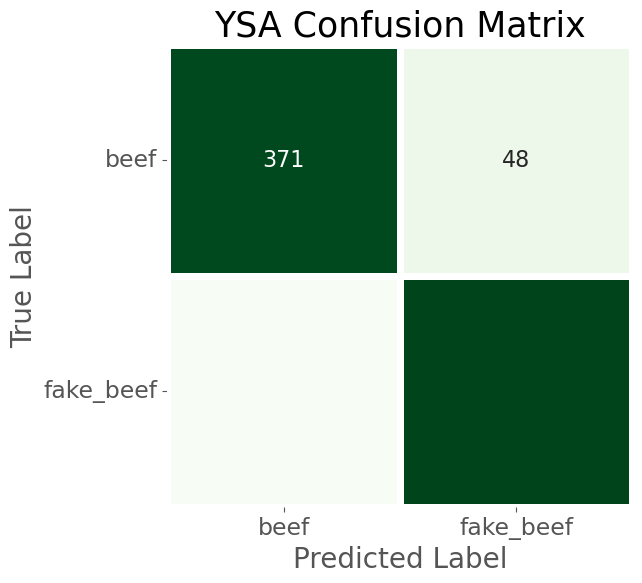

In [34]:
y_pred = cnn_model.predict(test_images)

def toClass(pred):
    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index
    return class_

cm = confusion_matrix(test_labels, toClass(y_pred))

df1 = pd.DataFrame(columns=["beef", "fake_beef"], index=["beef", "fake_beef"], data=cm)

f, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(df1, annot=True, cmap="Greens", fmt='.0f', ax=ax, linewidths=5, cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label", size=20)
plt.ylabel("True Label", size=20)
plt.title("YSA Confusion Matrix", size=25)

# Tăng cỡ chữ trục x và y
plt.xticks(size=17)  # Tăng kích thước chữ trên trục x
plt.yticks(size=17, rotation=0)  # Tăng kích thước chữ trên trục y và giữ không xoay

plt.show()


In [35]:
def Prediction(image):
    
    global width, height, files, labels
    
    img = cv2.resize(image,(width,height))
    
    test = img / 255.0
    
    pred = cnn_model.predict(np.array([image])).argmax()
    
    return labels.inverse_transform([pred])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


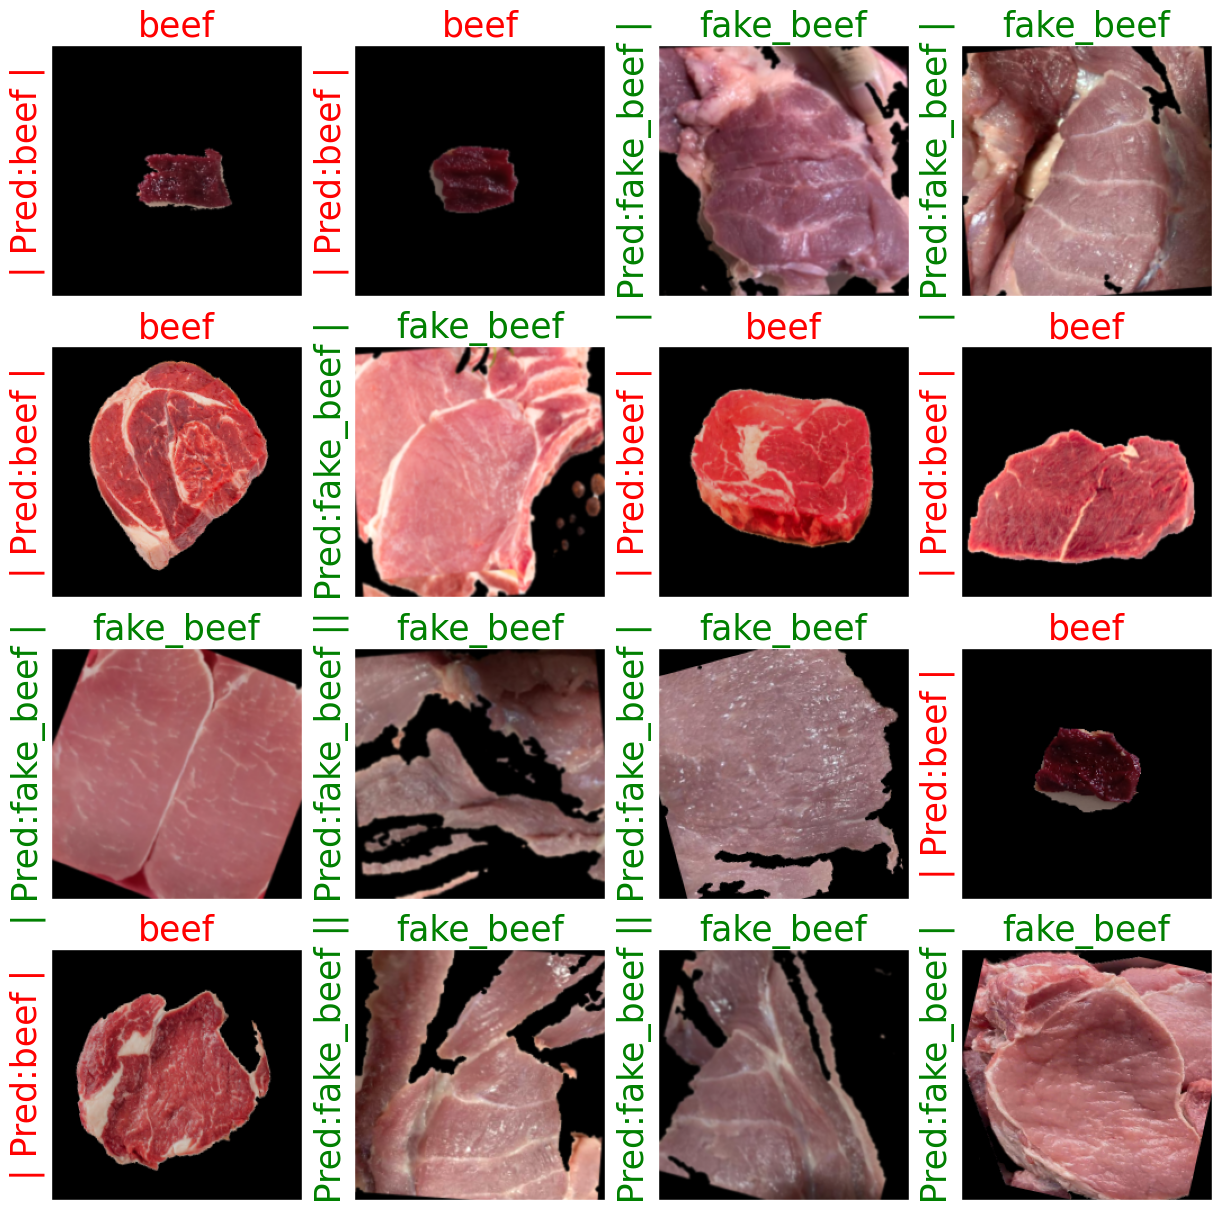

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for i in range(1, 17):
    fig = np.random.choice(np.arange(len(image_data)))  # Sử dụng len(image_data) thay vì size
    plt.subplot(4, 4, i)

    # Chuyển đổi ảnh từ BGR sang RGB
    img_rgb = cv2.cvtColor(image_data[fig], cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    
    # Đặt màu sắc cho tiêu đề dựa trên nhãn
    c = 'green' if image_target[fig] == 'fake_beef' else 'red'
    plt.title(image_target[fig], color=c,size=25)
    plt.ylabel("| Pred:{} |".format(Prediction(image_data[fig])), fontsize=25, color=c)
    plt.xticks([]), plt.yticks([])

plt.show()
